# Notebook 2: Useful Metrics to Track

In [126]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import xxhash
from tqdm import tqdm

from epic_clustering.scoring import weighted_v_score

all_colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
              'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
              'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
all_colors = all_colors*10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Roadmap

Our plan is to run the DBSCAN clustering and use the following metrics to track the progress of the project:
- Misclassification Heatmap
- Misclassification Histograms
- Total particle energy resolution
- Algorithm throughput

## 1. Load a CSV file

First, we load one of the CSV files. The exact way you do this will differ between a local notebook and a Kaggle notebook.

In [127]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

In [128]:
events = pd.read_csv(sorted(csv_files)[0])

In [129]:
sorted(csv_files)[0]

'/global/cfs/cdirs/m3443/data/PowerWeek/train/train/train_ePIC_event0_1000.csv'

## 2. Run Clustering and Labelling

In [203]:
def make_cluster_labels(event, eps=10, min_samples=1, features=['posx', 'posy']):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    event['tmp_clusterID'] = dbscan.fit_predict(event[features], sample_weight=event['E'])

    # encode the labels to make sure it's unique across all events 
    str_ids = event['event'].astype('str') + "_" + event['tmp_clusterID'].astype('str')
    event['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]
    
    return event

def add_classification(event):
    max_energy_indices = event.groupby('clusterID')['E'].idxmax()
    labels_with_max_energy = event.loc[max_energy_indices][["labelID", "clusterID", "E"]]
    max_energy_indices = labels_with_max_energy.groupby(['labelID'])['E'].idxmax()
    labels_with_max_energy = event.loc[max_energy_indices][["clusterID", "labelID"]]
    
    df_with_clusterID = pd.merge(event, labels_with_max_energy, on='labelID', how='left')
    df_with_clusterID.rename(columns={'clusterID_x': 'true_clusterID', 'clusterID_y': 'pred_clusterID'}, inplace=True)
    df_with_clusterID["correct_cluster"] = df_with_clusterID['true_clusterID'] == df_with_clusterID['pred_clusterID']
    
    reverse_df_with_clusterID = pd.merge(labels_with_max_energy, event, on='labelID', how='left')
    
    return df_with_clusterID

## 3. Misclassification Heatmap

It's tricky to define what "misclassification" means in the case of clustering. We can't just look at the labels, because the labels are arbitrary. Instead, let's look at the label of the highest energy hit in each particle as the "predicted label" for that particle. 

In [204]:
event = events[events['event'] == events.event.unique()[0]]
event = make_cluster_labels(event, eps=6, features=['posx', 'posy'])
homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=event["labelID"], labels_weight=event['E'])
print(f"Homogeneity: {homogeneity} \nCompleteness: {completeness} \nV-Score: {vscore}")

Homogeneity: 0.7526514875234618 
Completeness: 0.8544778191546157 
V-Score: 0.8003388389100524


In [205]:
event

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,clusterID,Efrac,uniqueID,tmp_clusterID,labelID
0,0,0,3797,4.893947,14.38,75,99,0,92.45672,212.575,367.28000,7336049725490893212,1.0,7336049725490893212,0,7336049725490893212
1,0,1,3797,2.370061,14.95,79,101,1,92.62984,222.575,383.28000,7336049725490893212,1.0,-7266117897785211713,0,7336049725490893212
2,0,2,3797,1.760534,14.71,75,98,1,92.45672,217.425,377.28000,7336049725490893212,1.0,1636848395396476578,0,7336049725490893212
3,0,3,3797,1.629804,15.19,78,101,1,97.54328,222.575,385.28000,7336049725490893212,1.0,1652180523553613148,0,7336049725490893212
4,0,4,3797,1.174102,15.28,78,100,1,97.54328,227.425,389.28000,7336049725490893212,1.0,5778831789312201101,0,7336049725490893212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,0,3792,3797,0.001650,51.32,49,31,1,-57.37016,-127.425,371.28000,15328574895278192162,1.0,-378538498875260065,-1,5204796701082899487
3793,0,3793,3797,0.001650,43.46,42,30,1,-62.62984,-122.575,387.28000,15328574895278192162,1.0,5205604446616455552,-1,5204796701082899487
3794,0,3794,3797,0.001650,79.11,46,21,3,-62.45672,-177.425,421.27997,15328574895278192162,1.0,-7790645447840131460,-1,5204796701082899487
3795,0,3795,3797,0.001650,89.56,44,38,0,-72.45672,-82.575,369.28000,15328574895278192162,1.0,-8865225153505007858,-1,5204796701082899487


In [206]:
event = add_classification(event)

In [207]:
event

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,true_clusterID,Efrac,uniqueID,tmp_clusterID,labelID,pred_clusterID,correct_cluster
0,0,0,3797,4.893947,14.38,75,99,0,92.45672,212.575,367.28000,7336049725490893212,1.0,7336049725490893212,0,7336049725490893212,7.336050e+18,True
1,0,1,3797,2.370061,14.95,79,101,1,92.62984,222.575,383.28000,7336049725490893212,1.0,-7266117897785211713,0,7336049725490893212,7.336050e+18,True
2,0,2,3797,1.760534,14.71,75,98,1,92.45672,217.425,377.28000,7336049725490893212,1.0,1636848395396476578,0,7336049725490893212,7.336050e+18,True
3,0,3,3797,1.629804,15.19,78,101,1,97.54328,222.575,385.28000,7336049725490893212,1.0,1652180523553613148,0,7336049725490893212,7.336050e+18,True
4,0,4,3797,1.174102,15.28,78,100,1,97.54328,227.425,389.28000,7336049725490893212,1.0,5778831789312201101,0,7336049725490893212,7.336050e+18,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,0,3792,3797,0.001650,51.32,49,31,1,-57.37016,-127.425,371.28000,15328574895278192162,1.0,-378538498875260065,-1,5204796701082899487,NaN,False
3793,0,3793,3797,0.001650,43.46,42,30,1,-62.62984,-122.575,387.28000,15328574895278192162,1.0,5205604446616455552,-1,5204796701082899487,NaN,False
3794,0,3794,3797,0.001650,79.11,46,21,3,-62.45672,-177.425,421.27997,15328574895278192162,1.0,-7790645447840131460,-1,5204796701082899487,NaN,False
3795,0,3795,3797,0.001650,89.56,44,38,0,-72.45672,-82.575,369.28000,15328574895278192162,1.0,-8865225153505007858,-1,5204796701082899487,NaN,False


In [208]:
correct_clusters = event[event['correct_cluster'] == True]
incorrect_clusters = event[event['correct_cluster'] == False]

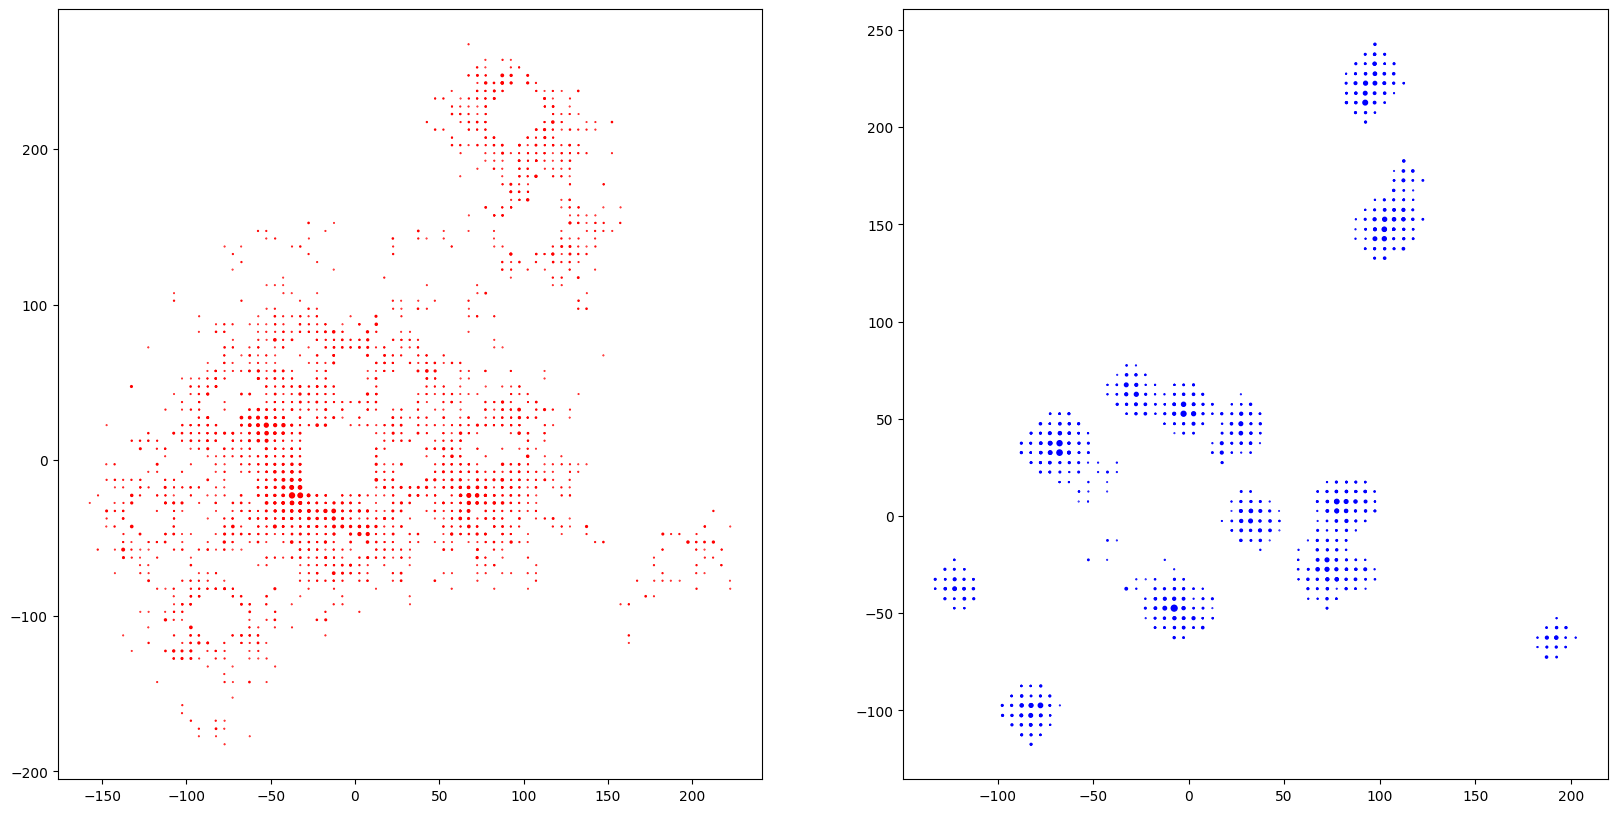

In [209]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].scatter(incorrect_clusters.posx, incorrect_clusters.posy, c="r", s=incorrect_clusters.E**(1/2)*5)
axs[1].scatter(correct_clusters.posx, correct_clusters.posy, c="b", s=correct_clusters.E**(1/2)*5)

## 4. Misclassification Distributions

In [210]:
labelled_events = []
pd.options.mode.chained_assignment = None
for event_id in tqdm(sorted(events['event'].unique())):
    event = events[events['event'] == event_id]
    event = make_cluster_labels(event, eps=6, features=['posx', 'posy'])
    labelled_events.append(event)
labelled_events = pd.concat(labelled_events)
homogeneity, completeness, vscore = weighted_v_score(labels_true=labelled_events['clusterID'], labels_pred=labelled_events["labelID"], labels_weight=labelled_events['E'])
print(f"Homogeneity: {homogeneity} \nCompleteness: {completeness} \nV-Score: {vscore}")
event = labelled_events

100%|██████████| 997/997 [00:26<00:00, 37.60it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Homogeneity: 0.9058949126036497 
Completeness: 0.9566039653139742 
V-Score: 0.9305591276632548


In [211]:
event = add_classification(event)

In [212]:
correct_clusters = event[event['correct_cluster'] == True]
incorrect_clusters = event[event['correct_cluster'] == False]

Let's see how our classification worked vs. hit energy

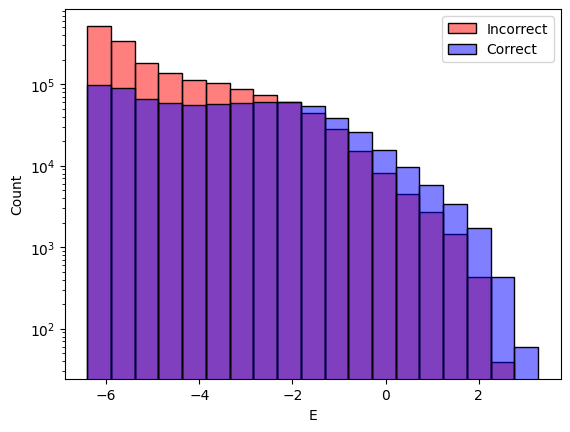

In [228]:
bins = np.linspace(min(np.log(event.E)), max(np.log(event.E)), 20)
sns.histplot(np.log(incorrect_clusters.E), bins=bins, color='r', alpha=0.5)
sns.histplot(np.log(correct_clusters.E), bins=bins, color='b', alpha=0.5)
plt.legend(['Incorrect', 'Correct'])
plt.yscale('log')

We can see a great number of misclassified hits, but these are mostly at very low energy. At higher energy, our performance seems to have more correctly than incorrectly classified hits.

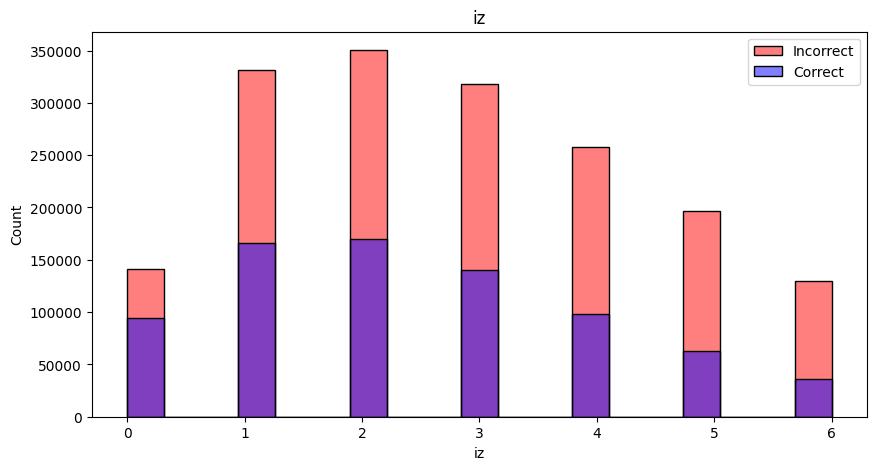

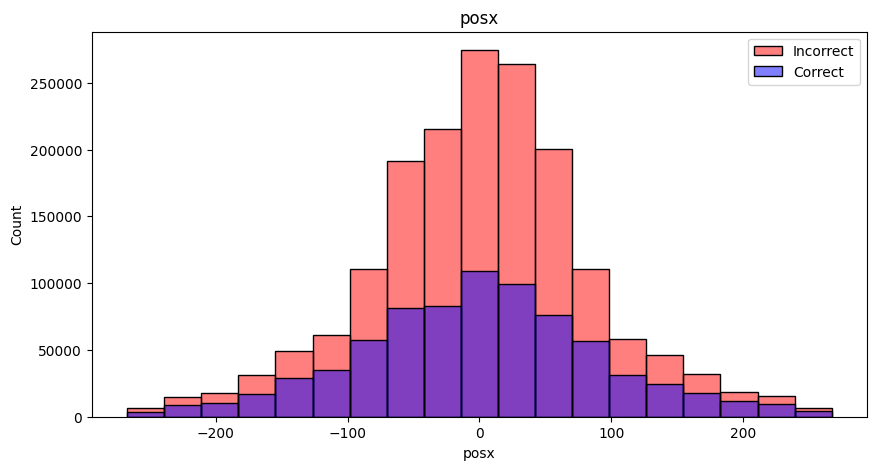

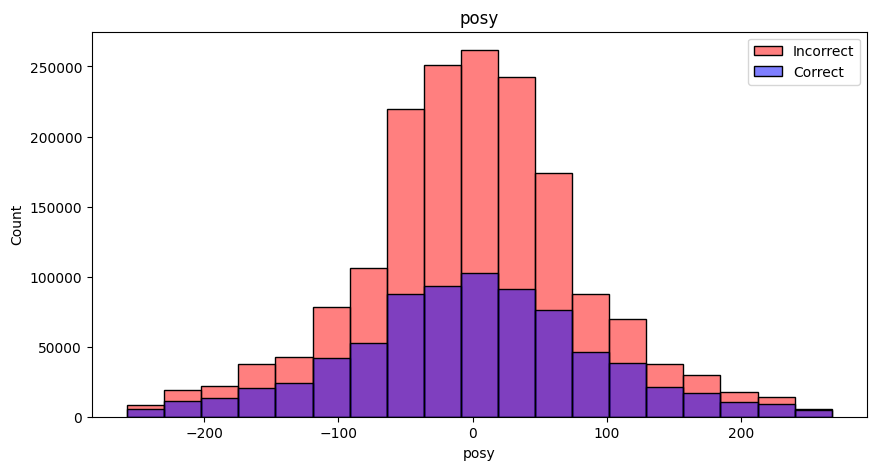

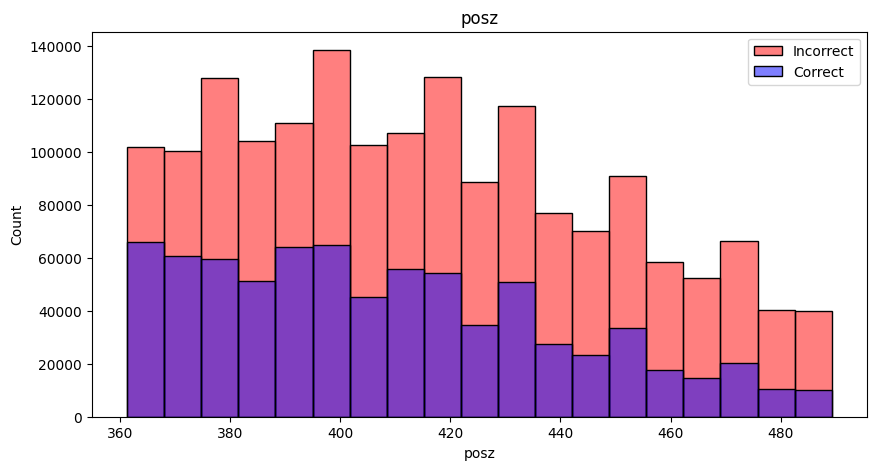

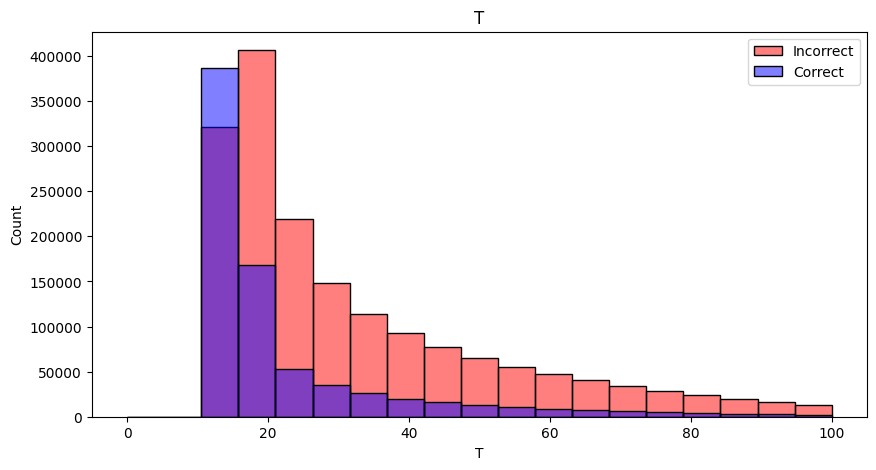

In [229]:
columns_to_compare = ["iz", "posx", "posy", "posz", "T"]

for column in columns_to_compare:
    plt.figure(figsize=(10, 5))
    bins = np.linspace(min(event[column]), max(event[column]), 20)
    sns.histplot(incorrect_clusters[column], bins=bins, color='r', alpha=0.5)
    sns.histplot(correct_clusters[column], bins=bins, color='b', alpha=0.5)
    plt.legend(['Incorrect', 'Correct'])
    plt.title(column)
    plt.show()

## 5. Energy Resolution Distribution

In [216]:
# sum E for each true_clusterID and pred_clusterID
true_energies = event.groupby('true_clusterID').agg({'E': 'sum'}).reset_index()
pred_energies = event.groupby('pred_clusterID').agg({'E': 'sum'}).reset_index()
combined_energies = true_energies.merge(pred_energies, left_on='true_clusterID', right_on='pred_clusterID').rename(columns={"E_x": "true_energy", "E_y": "pred_energy"})

In [217]:
energy_resolution = np.abs((combined_energies.true_energy - combined_energies.pred_energy) / combined_energies.true_energy)

<Axes: ylabel='Count'>

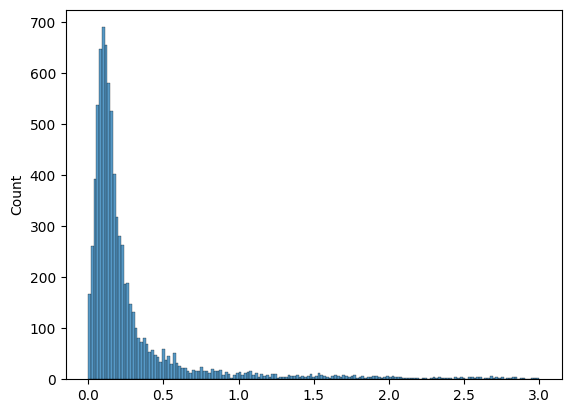

In [218]:
sns.histplot(energy_resolution, binrange=[0, 3])

In [219]:
np.round(true_energies.true_clusterID).astype(np.int64)

0        1515431603105207
1        4122135695119878
2        4598919028253334
3        5171453820613318
4        5760462407929670
               ...       
13529   -4413884168444351
13530   -3665059014044128
13531   -3557633143308489
13532   -2911320548309076
13533    -166457198261839
Name: true_clusterID, Length: 13534, dtype: int64

In [220]:
np.round(pred_energies.pred_clusterID).astype(np.int64)

0          1515431603105207
1          4122135695119878
2          5171453820613318
3          5760462407929670
4          6230160935796438
               ...         
8870   -9223372036854775808
8871   -9223372036854775808
8872   -9223372036854775808
8873   -9223372036854775808
8874   -9223372036854775808
Name: pred_clusterID, Length: 8875, dtype: int64

In [137]:
combined_energies

,true_clusterID,true_energy,pred_clusterID,pred_energy
0,1515431603105207,44.634845,1.515432e+15,25.100296
1,4122135695119878,6.065163,4.122136e+15,4.559079
2,4598919028253334,14.892990,4.598919e+15,35.863927
3,5171453820613318,70.438697,5.171454e+15,49.241351
4,5760462407929670,16.719509,5.760462e+15,14.259132
...,...,...,...,...
13529,18442330189541107265,17.691947,1.844233e+19,14.567607
13530,18443079014695507488,60.772045,1.844308e+19,141.201535
13531,18443186440566243127,4.575162,1.844319e+19,3.950789
13532,18443832753161242540,0.986460,1.844383e+19,9.509112
